## Brief description of the problem and data
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). In this starter competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

### Git Repo
Link: https://github.com/Lenni-A/Deep_Learning/tree/main/week4

### Data
Source data: https://www.kaggle.com/competitions/nlp-getting-started/data

**Files**<br>
train.csv - the training set<br>
test.csv - the test set<br>

**Columns**<br>
id - a unique identifier for each tweet<br>
text - the text of the tweet<br>
location - the location the tweet was sent from (may be blank)<br>
keyword - a particular keyword from the tweet (may be blank)<br>
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)<br>

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
df_full_train = pd.read_csv('./data/train.csv')
print("-- Train data --")
df_full_train.info()
df_test = pd.read_csv('./data/test.csv')
print("\n-- Test data --")
df_test.info()

-- Train data --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

-- Test data --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
Show a few visualizations like histograms. Describe any data cleaning procedures.
### Data Pre-Cleaning
- Add some stats for visualizations
- Create visualisations show initial stats

In [3]:
# Add target to test data. 3 = Unknown
df_test['target'] = 3
# Add additional stats to dataframe
def add_stats(col_text:str = 'text'):
    for df in [df_full_train, df_test]:
        df["length"]  = df[col_text].apply(len)
        df['word_count'] = df[col_text].apply(lambda x: len(str(x).split()))
        df['word_length_mean'] = df[col_text].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
        
add_stats()

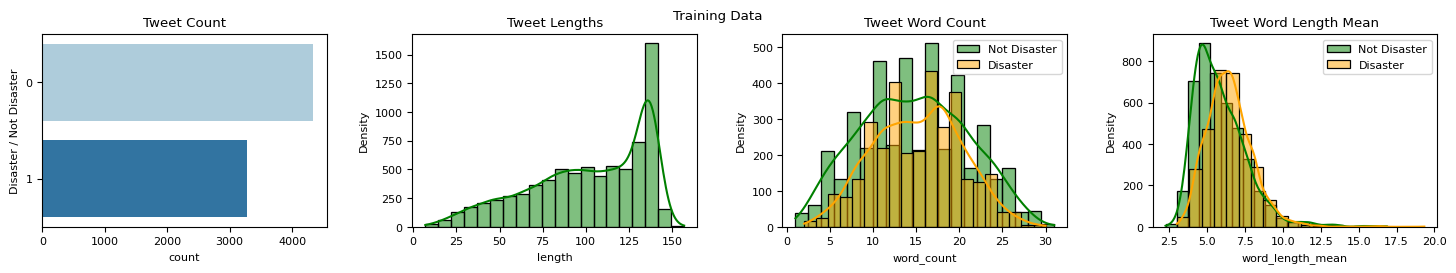

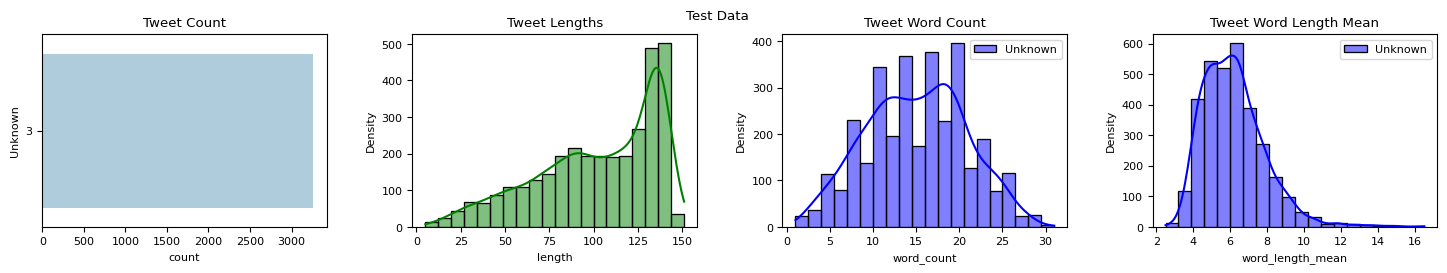

In [4]:
def show_visualizations():
    for df in [df_full_train, df_test]:
        main_title = 'Test Data'
        target_label = 'Unknown'
        if df.equals(df_full_train):
            main_title = 'Training Data'
            target_label = 'Disaster / Not Disaster'
        mask_disaster = df['target'] == 1
        mask_not_disaster = df['target'] == 0
        mask_unknown = df['target'] == 3
        plt.rcParams['font.size'] = 8
        fig,(ax1, ax2, ax3, ax4)=plt.subplots(1, 4, figsize=(18,2.5), gridspec_kw={'wspace': 0.3})
        sns.countplot(y='target', data=df, ax=ax1, palette='Paired')
        ax1.set_ylabel(target_label)
        ax1.set_title('Tweet Count')
        sns.histplot(df["length"], kde=True, color='green', bins=20, ax=ax2)
        ax2.set_ylabel('Density')
        ax2.set_title('Tweet Lengths')
        sns.histplot(df.loc[mask_not_disaster]["word_count"], label = 'Not Disaster', kde=True, color='green', bins=20, ax=ax3)
        sns.histplot(df.loc[mask_disaster]["word_count"], label = 'Disaster', kde=True, color='orange', bins=20, ax=ax3)
        sns.histplot(df.loc[mask_unknown]["word_count"], label = 'Unknown', kde=True, color='blue', bins=20, ax=ax3)
        ax3.set_ylabel('Density')
        ax3.set_title('Tweet Word Count')
        ax3.legend()
        sns.histplot(df.loc[mask_not_disaster]["word_length_mean"], label = 'Not Disaster', kde=True, color='green', bins=20, ax=ax4)
        sns.histplot(df.loc[mask_disaster]["word_length_mean"], label = 'Disaster', kde=True, color='orange', bins=20, ax=ax4)
        sns.histplot(df.loc[mask_unknown]["word_length_mean"], label = 'Unknown', kde=True, color='blue', bins=20, ax=ax4)
        ax4.set_ylabel('Density')
        ax4.set_title('Tweet Word Length Mean')
        ax4.legend()
        fig.suptitle(main_title)
        
show_visualizations()

### Data Cleaning / Post visualizations
Data cleansing is crucial and enhances the reliability of machine learning models by preventing them from learning patterns based on noisy or inaccurate information, leading to more accurate and robust predictions.

- Do following cleaning:
    - Removal of non alpha words
    - Removal of short words (t <= 2)
    - Removal of stop words
- Update some stats for visualizations
- Create visualisations show stats post data cleaning

e:\Learn\_Code_\3_Introduction to Deep Learning\.venv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


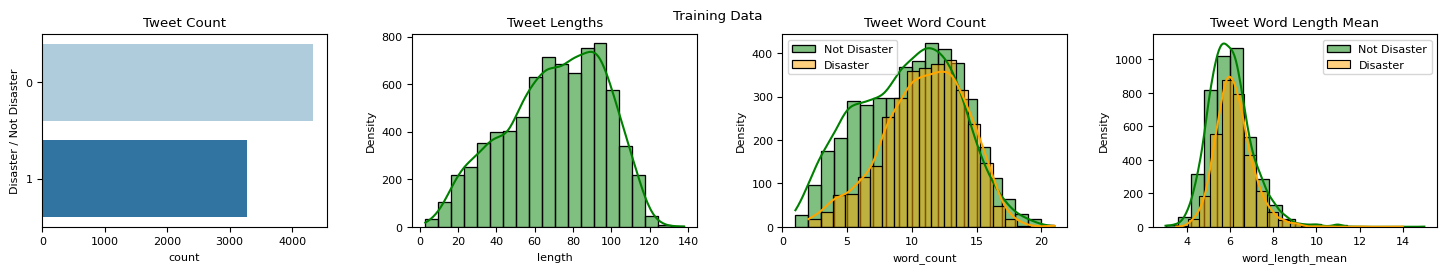

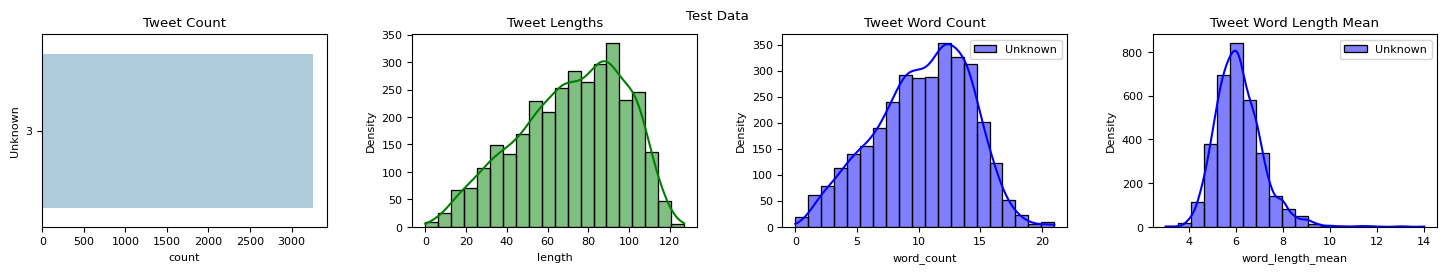

In [5]:
def clean_text(text):
    text = text.lower()
    # Remove non alpha chars
    text = ''.join([t if t.isalpha() else " " for t in text])
    # Remove URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(text, text)
    # Remove html tags
    html = re.compile(r'<.*?>')
    text = html.sub(text, text)
    # Create tokens
    words = word_tokenize(text)
    # Create stopwords which have no significant meaning eg. the, or
    stop_words = set(stopwords.words('english'))
    # Remove words which have length <= 2 or a stop word 
    text = ' '.join([w for w in words if len(w) > 2 and w not in stop_words])
    return text

# Create a clean text column
df_full_train['clean_text'] = df_full_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

# Show visualizations post data cleaning
add_stats('clean_text')
show_visualizations()

## DModel Architecture
Describe model architecture and reasoning for why that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

### Create Model
Use LSTM which is very well-suited for NLP tasks due to their ability to capture long-range dependencies in sequential data, making them effective for understanding context, semantic relationships, and handling variable-length sequences of words, which are essential aspects of natural language processing tasks.

Before training LSTM an embedding config will be defined as the first layer. Additionally the text must be transformed into numerical representations, allowing the model to process and learn patterns effectively. The vectorization method main idea is to evaluate the importance of the term (word) within a document relative to a collection of documents.

In [6]:
# Create train and validation data set.
# df_train, df_valid = train_test_split(df_full_train, test_size=0.2, random_state=42)

# Setup some params for later tuning.
# Iteration count
epoch = 5
# Size of vectorization features and embedding vocabulary
vec_features = 2000
# Vector length for each word
embed_vec_length = 8
# Count of LSTM units
lstm_unit_size = 25

# Create function for later tuning.
def create_model(x_vec, embed_vocab_size:int, embed_vec_length:int, lstm_unit_size:int):
    model = Sequential()
    model.add(Embedding(embed_vocab_size, embed_vec_length, input_length = x_vec.shape[1]))
    model.add(Dropout(0.3))
    model.add(LSTM(lstm_unit_size))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
    return model

def create_vec_train_valid(vec_features:int):
    tokenizer=Tokenizer(num_words=vec_features, split=' ')
    tokenizer.fit_on_texts(df_full_train['clean_text'].values)
    x_vec = tokenizer.texts_to_sequences(df_full_train['clean_text'].values)
    # Pad sequences for input to LSTM
    x_vec = pad_sequences(x_vec, maxlen=10)
    X_train, X_valid, y_train, y_valid = train_test_split(x_vec, df_full_train['target'], test_size=0.2, random_state=42)
    return X_train, X_valid, y_train, y_valid

def create_vec_train_valid_tfid(vec_features:int):
    vectorizer = TfidfVectorizer(max_features=vec_features)
    x_vec = vectorizer.fit_transform(df_full_train['clean_text']).toarray()
    # Pad sequences for input to LSTM
    x_vec = pad_sequences(x_vec)
    X_train, X_valid, y_train, y_valid = train_test_split(x_vec, df_full_train['target'], test_size=0.2, random_state=42)
    return X_train, X_valid, y_train, y_valid

def train_model(epoch:int, vec_features:int, embed_vec_length:int, lstm_unit_size:int):
    X_train, X_valid, y_train, y_valid = create_vec_train_valid(vec_features)
    lstm_model = create_model(X_train, vec_features, embed_vec_length, lstm_unit_size)
    lstm_model.summary()
    return lstm_model, lstm_model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_valid, y_valid))

model, model_trained = train_model(epoch, vec_features, embed_vec_length, lstm_unit_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 8)             16000     
                                                                 
 dropout (Dropout)           (None, 10, 8)             0         
                                                                 
 lstm (LSTM)                 (None, 25)                3400      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 19,426
Trainable params: 19,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
191/191 [==============================] -

## Results and Analysis
Based on the training output, the LSTM model shows limited improvement over epochs with the accuracy plateauing around 56.95% and the validation accuracy remains stagnant at 57.39%, suggesting that the model struggles to learn meaningful patterns in the data. Possible reasons include the model architecture, insufficient complexity or the need for more iterations.

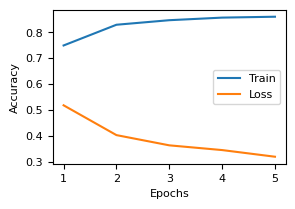

In [7]:
def plot_learning_curve(model_res, epochs):
    epoch_range = range(1, epochs+1)
    plt.figure(figsize=(3, 2))
    plt.plot(epoch_range, model_res.history['accuracy'])
    plt.plot(epoch_range, model_res.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Loss"])
    plt.show()
    
plot_learning_curve(model_trained, epoch)

### Fine tuning model
Run training using set of hyperparameters

In [8]:
best_acc = 0
best_model = None
model_trained = None
df = pd.DataFrame(columns=['Epoch', 'Vector_Size', 'Vector_Len', 'LSTM_Unit_Size', 'Loss', 'Acc'])

# Iteration count
epochs = [5, 10, 15]
# Size of vectorization features and embedding vocabulary
vec_features = [3000, 4000, 5000]
# Vector length for each word
embed_vec_length =[16, 32, 64]
# Count of LSTM units
lstm_unit_size = [50, 100, 200]
for i, epoch in enumerate(epochs):
    print('----- TRAINING MODEL -----')
    m, mt = train_model(epoch, vec_features[i], embed_vec_length[i], lstm_unit_size[i])
    acc = np.mean(mt.history['accuracy'])
    loss = np.mean(mt.history['loss'])
    print(f'MEAN ACCURACY: {acc}')
    if acc > best_acc:
        best_acc = acc
        best_model = m
        model_trained = mt
    df.loc[len(df)] = [epoch, vec_features[i], embed_vec_length[i], lstm_unit_size[i], loss, acc]

----- TRAINING MODEL -----
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 16)            48000     
                                                                 
 dropout_2 (Dropout)         (None, 10, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                13400     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 61,451
Trainable params: 61,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
191/191 [====

#### Measurement
Plot the training result of the best model which has the highest epoch and other hyperparameters for Loss and Accuracy.

Looking at the calculation logs and the stats, the best LSTM model achieves a high accuracy of approximately 94%, indicating effective learning on the training data. However, the validation accuracy of around 75% suggests a considerable performance drop on test data, signaling potential overfitting.  Additionally the imbalanced values in the Loss and Acc columns across different epochs and other hyperparameters suggest that the models may not have been trained for a sufficient duration or with appropriate steps, potentially leading to biased results.

Exec Hyperparameters:
    Epoch  Vector_Size  Vector_Len  LSTM_Unit_Size      Loss       Acc
2   15.0       5000.0        64.0           200.0  0.133869  0.942408


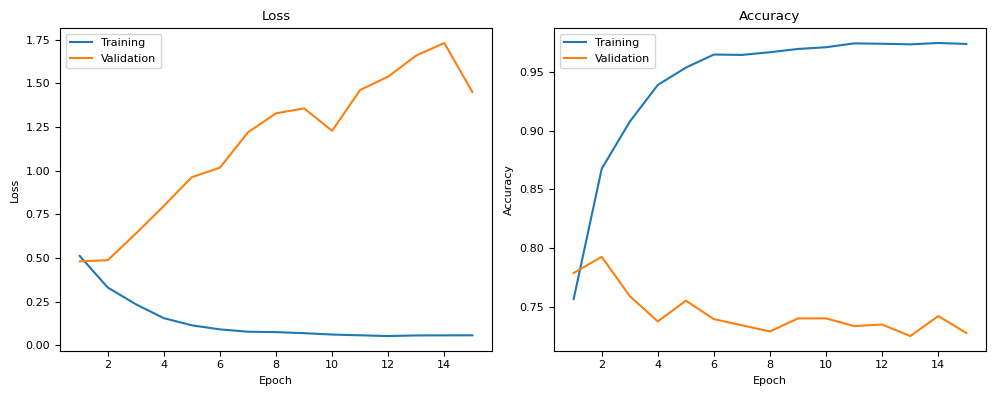

In [9]:
def plot_metrics(history, metrics):
    epoch_cnt = range(1, len(history[metrics[0]]) + 1)
    metrics_cnt = len(metrics)
    plt.figure(figsize=(10, 4))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, metrics_cnt, i)
        plt.plot(epoch_cnt, history[metric], label='Training')
        plt.plot(epoch_cnt, history[f'val_{metric}'], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.title(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

print("Exec Hyperparameters:\n", df.tail(1))
plot_metrics(model_trained.history, ['loss', 'accuracy'])

#### Trained model with test data / Kaggle Submission
Use the trained model with test data. Save result for Kaggle submission.

In [20]:
tokenizer=Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(df_test['clean_text'].values)
x_vec = tokenizer.texts_to_sequences(df_test['clean_text'].values)
# Pad sequences for input to LSTM
x_vec = pad_sequences(x_vec, 10)
pred_values = model.predict(x_vec, verbose=1)
df = df_test.drop(['keyword','location','text','length','word_count','word_length_mean','clean_text'],axis=1)
df['target'] = np.round(pred_values).astype('int')
df.to_csv('submission.csv', index=False)


102/102 [==============================] - 0s 2ms/step


## Conclusion
The created LSTM model with a total of 532,201 parameters is trained on approx. 8500 tweets using the Adam optimizer and binary cross-entropy loss function. It's architecture includes an embedding layer, followed by a dropout layer, a LSTM layer with 200 units, another dropout layer and finally a dense layer with one output unit. The setup should provide the approriate setup to identify a high amount of tweets correctly. The training logs show a gradual decrease in loss and increase in accuracy over the 15 epochs that shows slight overfitting indicated by the higher accuracy on the training set compared to the validation set. Additionally due to the indicated overfitting the Kaggle scoring returned only approx. 55%.

To enhance the model several improvements could be explored such as hyperparameter tuning, trying different architectures and consideration of other embedding techniques. Additionally experimenting with different optimizers or learning rate schedules may achieve better stability and convergence during training.